In [1]:
import torch
from torch import nn
import gpytorch
# from torchsummary import summary

import matplotlib.pyplot as plt
import gc

from warp_units import *
from func_polygon import *
from func_data_generation import *

from utils import *

dtype=torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
# device =  "cpu"
print("Using {} device".format(device))

import tqdm
torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using cuda device


In [2]:

data_dim = 2

class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(1000, 500))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(500, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 2))
        
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, warp_model):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
#             self.covar_module = gpytorch.kernels.GridInterpolationKernel(
#                 gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
#                 num_dims=2, grid_size=100
#             )
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            self.covar_module2 = gpytorch.kernels.LinearKernel() * gpytorch.kernels.LinearKernel()
            self.space_transform = warp_model

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.space_transform(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x) + self.covar_module2(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
train_X = torch.load(DATA_PATH+ '/train_X').to(device)
train_y = torch.load(DATA_PATH+ '/train_y').to(device)

In [ ]:
train_X

In [5]:
warp_model = LargeFeatureExtractor().to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
gp_model = GPRegressionModel(train_x=train_X, train_y=train_y, likelihood=likelihood, warp_model=warp_model).to(device)
gp_model.covar_module.outputscale = 13

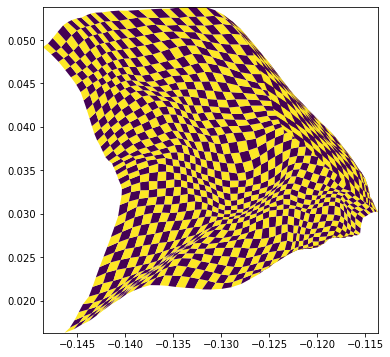

In [6]:
chessboard_from_model(warp_model)

In [336]:
# for name, param in gp_model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
# #     print(f"Layer:{name} | Size:{param.size()} |  \n")

In [17]:
gp_model.train()
likelihood.train()
training_iterations = 1000
# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': gp_model.space_transform.parameters()},
    {'params': gp_model.covar_module.parameters()},
    {'params': gp_model.mean_module.parameters()},
    {'params': gp_model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = gp_model(train_X)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        iterator.set_postfix(loss=loss.item(), output_scale = gp_model.covar_module.outputscale.item(), 
                             leng_scale = gp_model.covar_module.base_kernel.lengthscale.item(), noise=gp_model.likelihood.noise.item())
        optimizer.step()

%time train()

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 12min 38s, sys: 19.9 s, total: 12min 58s
Wall time: 19.5 s


In [18]:

# for name, param in gp_model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")

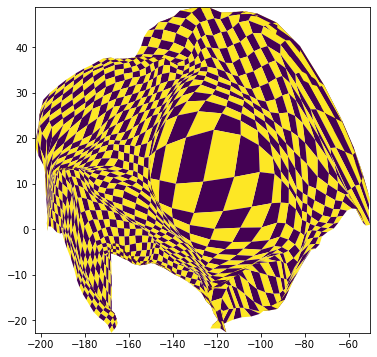

In [19]:
chessboard_from_model(warp_model)

In [20]:
oned_map(warp_model.axial_dim0, dim=0)

AttributeError: 'LargeFeatureExtractor' object has no attribute 'axial_dim0'

In [21]:
chessboard_from_model(warp_model.mobius)

AttributeError: 'LargeFeatureExtractor' object has no attribute 'mobius'

In [22]:
for name, param in gp_model.named_parameters():
    print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
#     print(f"Layer:{name} | Size:{param.size()} |  \n")


Layer:likelihood.noise_covar.raw_noise | Size:torch.Size([1]) | Values : Parameter containing:
tensor([-2.1236], device='cuda:0', requires_grad=True) 

Layer:covar_module.raw_outputscale | Size:torch.Size([]) | Values : 37.5984656311222 

Layer:covar_module.base_kernel.raw_lengthscale | Size:torch.Size([1, 1]) | Values : Parameter containing:
tensor([[-0.2489]], device='cuda:0', requires_grad=True) 

Layer:covar_module2.kernels.0.raw_variance | Size:torch.Size([1, 1]) | Values : Parameter containing:
tensor([[0.]], device='cuda:0', requires_grad=True) 

Layer:covar_module2.kernels.1.raw_variance | Size:torch.Size([1, 1]) | Values : Parameter containing:
tensor([[0.]], device='cuda:0', requires_grad=True) 

Layer:space_transform.linear1.weight | Size:torch.Size([1000, 2]) | Values : Parameter containing:
tensor([[-1.5619, -0.5565],
        [-0.0298,  0.0828],
        [-0.6960,  0.0157],
        ...,
        [-0.0038,  0.0238],
        [-0.1387, -0.2833],
        [-0.1282, -0.4196]], dev

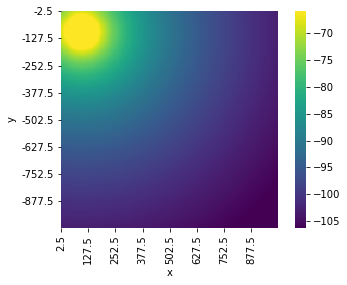

In [23]:
likelihood.eval()
gp_model.eval()
coords, rss = get_field_data(200, 30, torch.tensor([[100, -100]]))  # 200*200显存上限
coords = coords.to(device)
observed_pred = likelihood(gp_model(coords/1000))
mean = observed_pred.mean.detach()
var = observed_pred.variance.detach()

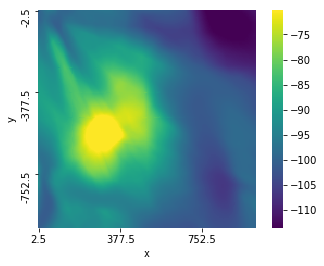

In [24]:
plot_heatmap(coords, mean)

In [344]:
gp_model.set_train_data(train_X, train_y, strict=False)

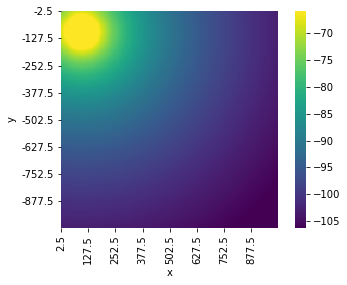

In [297]:
likelihood.eval()
gp_model.eval()
coords, rss = get_field_data(200, 30, torch.tensor([[100, -100]]))  # 200*200显存上限
coords = coords.to(device)
observed_pred = likelihood(gp_model(coords/1000))
mean = observed_pred.mean.detach()
var = observed_pred.variance.detach()

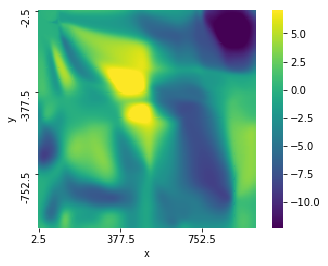

In [298]:


plot_heatmap(coords, mean)

In [21]:
point = torch.tensor([[2.5, -2.5]]).to(device)
warp_model(point)

tensor([[ 2.6314, -1.8408]], device='cuda:0', grad_fn=<StackBackward>)

In [353]:
gp_model.covar_module2

ProductKernel(
  (kernels): ModuleList(
    (0): LinearKernel(
      (raw_variance_constraint): Positive()
    )
    (1): LinearKernel(
      (raw_variance_constraint): Positive()
    )
  )
)